In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 005930.KS.csv to 005930.KS.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# close 예측

### STEP 1 : 시계열 데이터 준비

In [ ]:
df = pd.read_csv("005930.KS.csv",index_col='Date',parse_dates=True)
ts = df['Close']
ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [ ]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

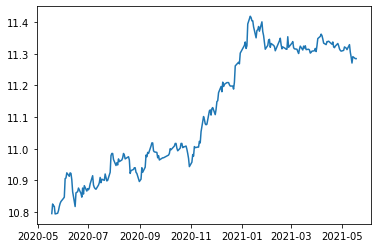

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

In [ ]:
def plot_rolling_statistics(timeseries,window=12):
  rolmean = timeseries.rolling(window=window).mean()
  rolstd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries,color='blue',label='Original')
  mean = plt.plot(rolmean,color='red',label='mean')
  std = plt.plot(rolstd,color='black',label='std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries,autolag = 'AIC')

  print("results of dickey -fuller test : ")
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)

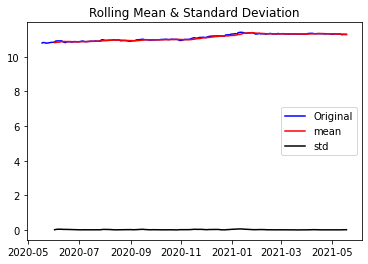

results of dickey -fuller test : 
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


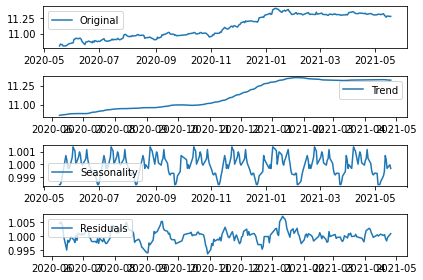

In [ ]:
plot_rolling_statistics(ts_log,window=12)

augmented_dickey_fuller_test(ts_log)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,model='multiplicative',period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

results of dickey -fuller test : 
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

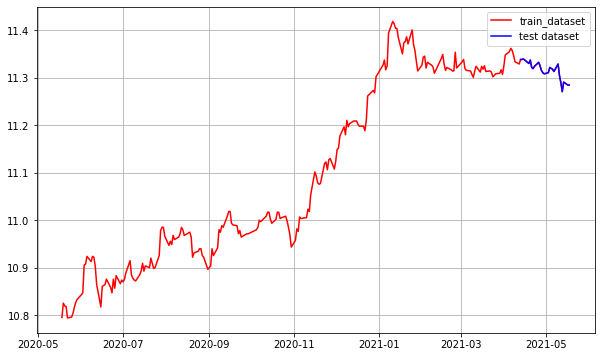

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log,c='r',label='train_dataset')
plt.plot(test_data,c='b',label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

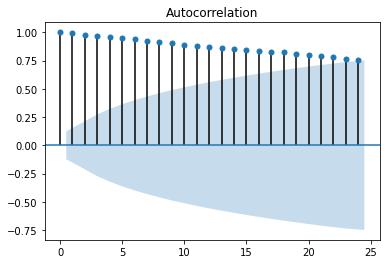

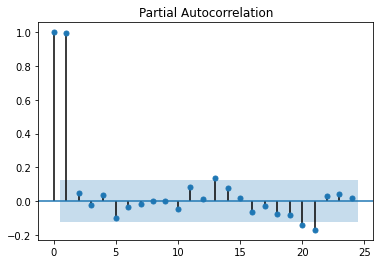

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

results of dickey -fuller test : 
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


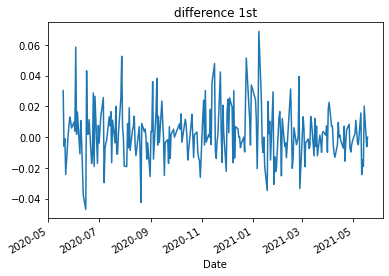

In [ ]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="difference 1st")

augmented_dickey_fuller_test(diff_1)

results of dickey -fuller test : 
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


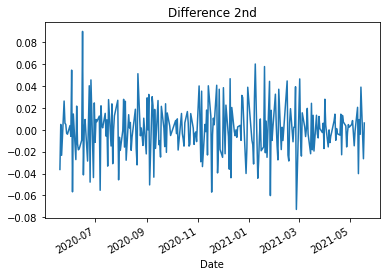

In [ ]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 583.409
Date:                Fri, 16 Dec 2022   AIC                          -1158.817
Time:                        05:53:56   BIC                          -1145.153
Sample:                             0   HQIC                         -1153.302
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.132     83.895      0.000      10.831      11.349
ar.L1          1.0296      0.061     16.764      0.000       0.909       1.150
ar.L2         -0.0350      0.062     -0.562      0.5

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


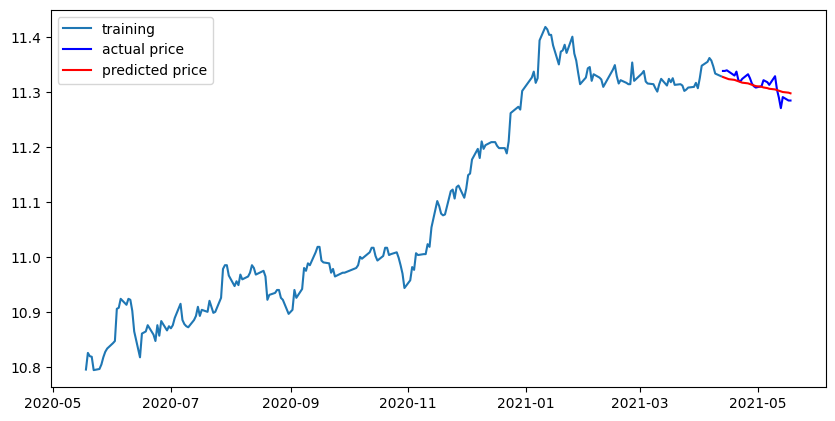

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc))
print("mse : ",mse)

mae = mean_absolute_error(np.exp(test_data),np.exp(fc))
print("mae : ",mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print("rmse : ",rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

mse :  1052831.395368831
mae :  840.3252917506366
rmse :  1026.0757259426962
MAPE: 1.02%


# Adj Close 예측

### STEP 1 : 시계열 데이터 준비

In [ ]:
df = pd.read_csv("005930.KS.csv",index_col='Date',parse_dates=True)
ts = df['Adj Close']
ts.head()

Date
2020-05-18    46788.835938
2020-05-19    48227.015625
2020-05-20    47939.382813
2020-05-21    47891.437500
2020-05-22    46740.894531
Name: Adj Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [ ]:
ts[ts.isna()]

Series([], Name: Adj Close, dtype: float64)

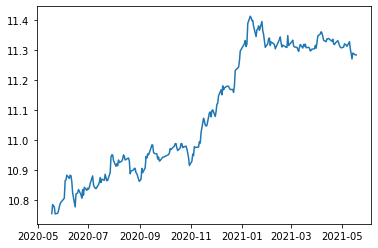

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

In [ ]:
def plot_rolling_statistics(timeseries,window=12):
  rolmean = timeseries.rolling(window=window).mean()
  rolstd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries,color='blue',label='Original')
  mean = plt.plot(rolmean,color='red',label='mean')
  std = plt.plot(rolstd,color='black',label='std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries,autolag = 'AIC')

  print("results of dickey -fuller test : ")
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)

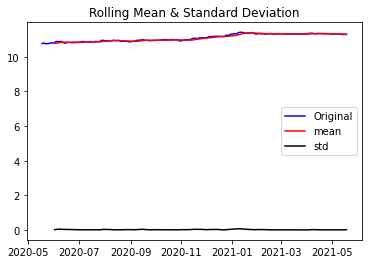

results of dickey -fuller test : 
Test Statistic                  -1.325541
p-value                          0.617408
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


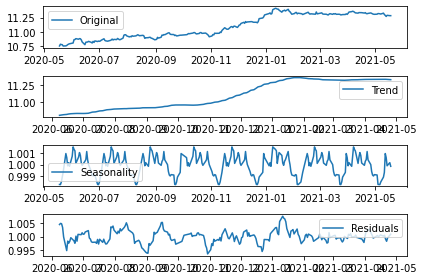

In [ ]:
plot_rolling_statistics(ts_log,window=12)

augmented_dickey_fuller_test(ts_log)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,model='multiplicative',period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

results of dickey -fuller test : 
Test Statistic                -6.217496e+00
p-value                        5.321736e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

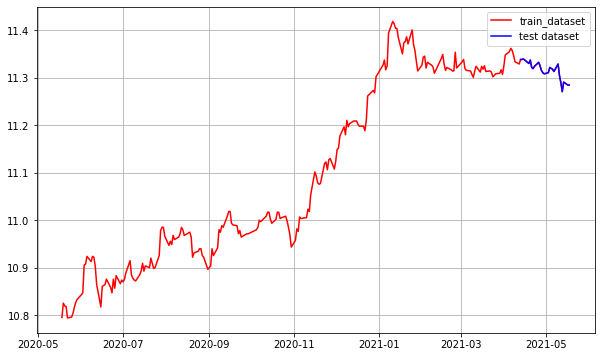

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log,c='r',label='train_dataset')
plt.plot(test_data,c='b',label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

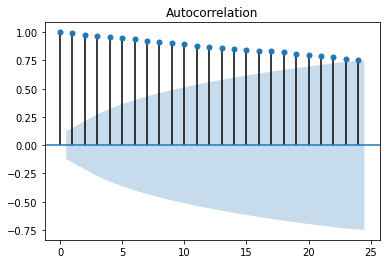

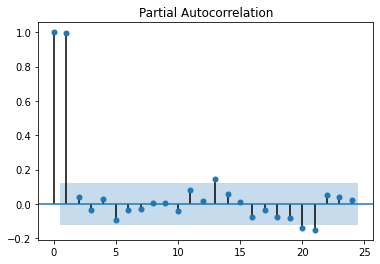

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

results of dickey -fuller test : 
Test Statistic                -1.529338e+01
p-value                        4.411838e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


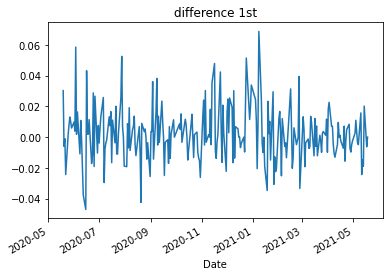

In [ ]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="difference 1st")

augmented_dickey_fuller_test(diff_1)

results of dickey -fuller test : 
Test Statistic                -1.012109e+01
p-value                        9.440906e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


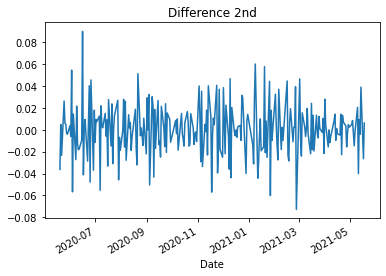

In [ ]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(13, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(13, 0, 0)   Log Likelihood                 586.032
Date:                Fri, 16 Dec 2022   AIC                          -1142.065
Time:                        06:07:53   BIC                          -1090.823
Sample:                             0   HQIC                         -1121.383
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0850      0.195     56.820      0.000      10.703      11.467
ar.L1          1.0409      0.068     15.421      0.000       0.909       1.173
ar.L2         -0.0573      0.109     -0.525      0.6

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


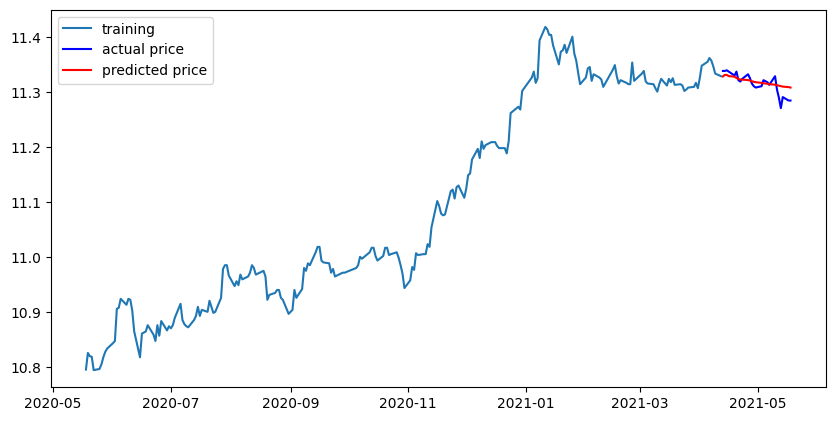

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc))
print("mse : ",mse)

mae = mean_absolute_error(np.exp(test_data),np.exp(fc))
print("mae : ",mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print("rmse : ",rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

mse :  1245891.3374691182
mae :  849.3655078065623
rmse :  1116.1950266280164
MAPE: 1.05%


# Volume 예측

### STEP 1 : 시계열 데이터 준비

In [ ]:
df = pd.read_csv("005930.KS.csv",index_col='Date',parse_dates=True)
ts = df['Volume']
ts.head()

Date
2020-05-18    20481981
2020-05-19    25168295
2020-05-20    14896899
2020-05-21    14949266
2020-05-22    19706284
Name: Volume, dtype: int64

### STEP 2 : 각종 전처리 수행

In [ ]:
ts[ts.isna()]

Series([], Name: Volume, dtype: int64)

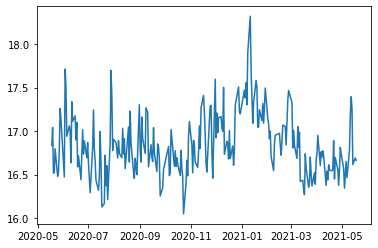

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

In [ ]:
def plot_rolling_statistics(timeseries,window=12): #12
  rolmean = timeseries.rolling(window=window).mean()
  rolstd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries,color='blue',label='Original')
  mean = plt.plot(rolmean,color='red',label='mean')
  std = plt.plot(rolstd,color='black',label='std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries,autolag = 'AIC')

  print("results of dickey -fuller test : ")
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)

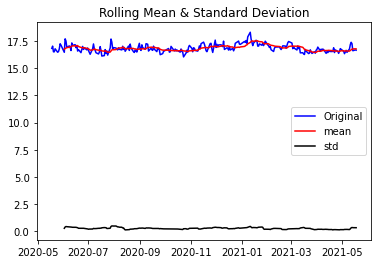

results of dickey -fuller test : 
Test Statistic                  -3.615129
p-value                          0.005478
#Lags Used                       4.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


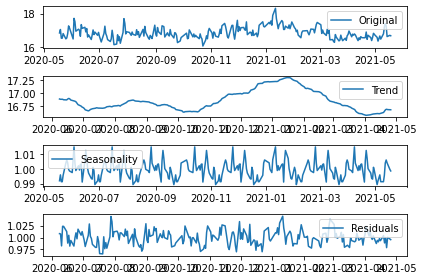

In [ ]:
plot_rolling_statistics(ts_log,window=12)

augmented_dickey_fuller_test(ts_log)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,model='multiplicative',period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

results of dickey -fuller test : 
Test Statistic                -1.020222e+01
p-value                        5.929287e-18
#Lags Used                     0.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

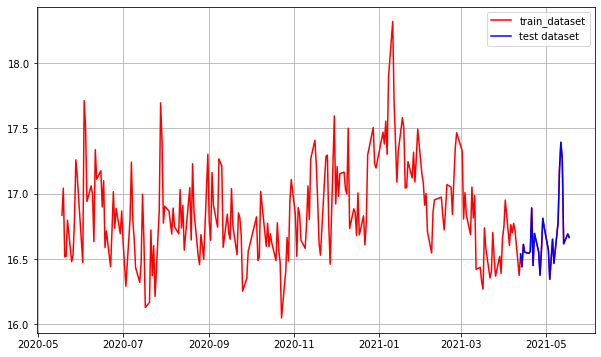

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log,c='r',label='train_dataset')
plt.plot(test_data,c='b',label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

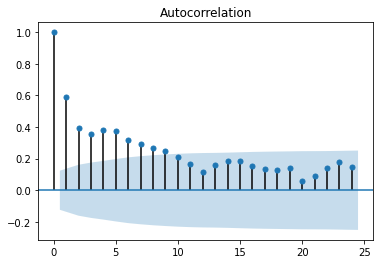

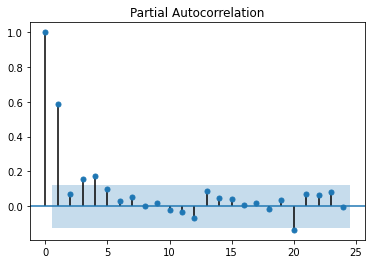

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

results of dickey -fuller test : 
Test Statistic                -1.232943e+01
p-value                        6.477059e-23
#Lags Used                     3.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


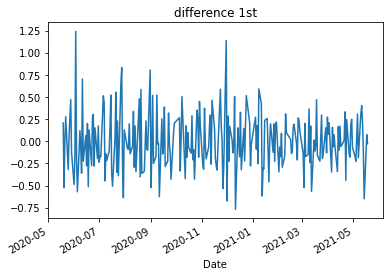

In [ ]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="difference 1st")

augmented_dickey_fuller_test(diff_1)

results of dickey -fuller test : 
Test Statistic                -1.025571e+01
p-value                        4.366954e-18
#Lags Used                     9.000000e+00
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


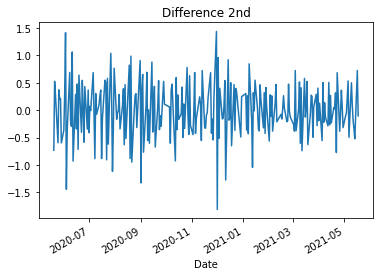

In [ ]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(14, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  225
Model:                ARIMA(14, 1, 0)   Log Likelihood                 -32.073
Date:                Fri, 16 Dec 2022   AIC                             94.146
Time:                        06:40:54   BIC                            145.321
Sample:                             0   HQIC                           114.803
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4983      0.067     -7.399      0.000      -0.630      -0.366
ar.L2         -0.5005      0.087     -5.752      0.000      -0.671      -0.330
ar.L3         -0.3966      0.099     -4.019      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


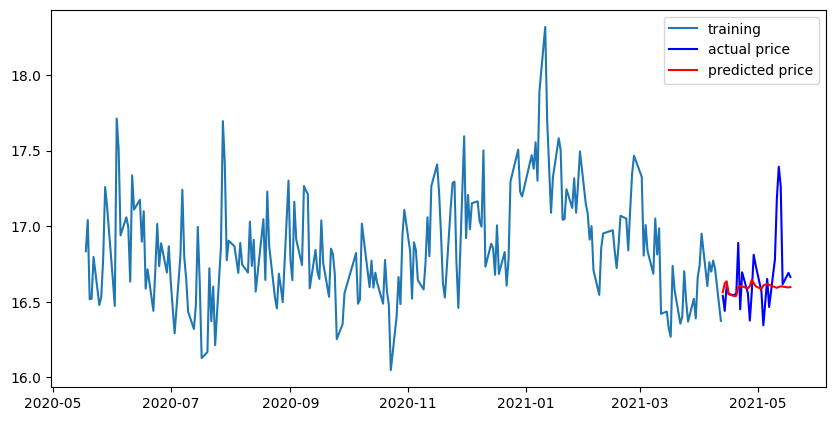

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc))
print("mse : ",mse)

mae = mean_absolute_error(np.exp(test_data),np.exp(fc))
print("mae : ",mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print("rmse : ",rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

mse :  35904229257992.03
mae :  3411528.8195571555
rmse :  5992013.789869983
MAPE: 15.16%


In [ ]:
# 15,1,0 -> 15.27%
# 7,1,0 -> 15.75%
# 20,1,0 -> 15.42%
#23 ,1,0 -> 15.53%
#14,1,0 -> 15.16%
#13,1,0 -> 15.34%

# Open 예측

### STEP 1 : 시계열 데이터 준비

In [ ]:
df = pd.read_csv("005930.KS.csv",index_col='Date',parse_dates=True)
ts = df['Open']
ts.head()

Date
2020-05-18    47950.0
2020-05-19    50100.0
2020-05-20    50000.0
2020-05-21    50300.0
2020-05-22    49600.0
Name: Open, dtype: float64

### STEP 2 : 각종 전처리 수행

In [ ]:
ts[ts.isna()]

Series([], Name: Open, dtype: float64)

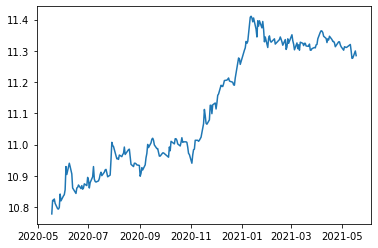

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

In [ ]:
def plot_rolling_statistics(timeseries,window=12): #12
  rolmean = timeseries.rolling(window=window).mean()
  rolstd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries,color='blue',label='Original')
  mean = plt.plot(rolmean,color='red',label='mean')
  std = plt.plot(rolstd,color='black',label='std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries,autolag = 'AIC')

  print("results of dickey -fuller test : ")
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)

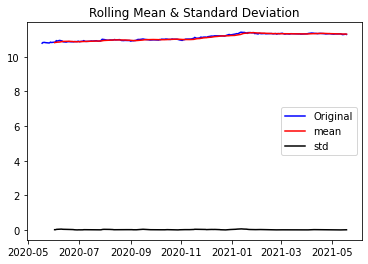

results of dickey -fuller test : 
Test Statistic                  -1.496329
p-value                          0.535327
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


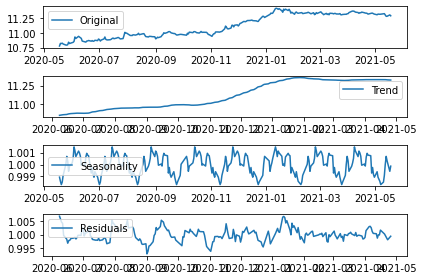

In [ ]:
plot_rolling_statistics(ts_log,window=12)

augmented_dickey_fuller_test(ts_log)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,model='multiplicative',period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

results of dickey -fuller test : 
Test Statistic                -6.055312e+00
p-value                        1.249248e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

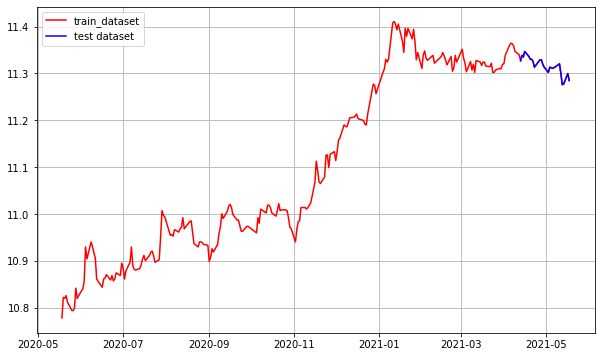

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log,c='r',label='train_dataset')
plt.plot(test_data,c='b',label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

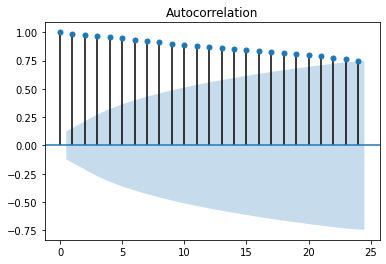

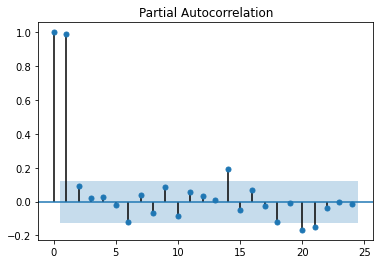

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

results of dickey -fuller test : 
Test Statistic                -1.672693e+01
p-value                        1.393437e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


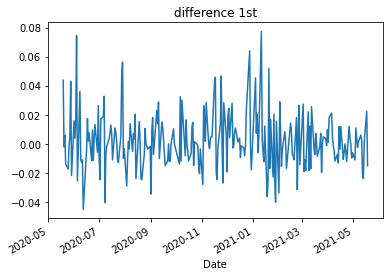

In [ ]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="difference 1st")

augmented_dickey_fuller_test(diff_1)

results of dickey -fuller test : 
Test Statistic                -1.044704e+01
p-value                        1.470936e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


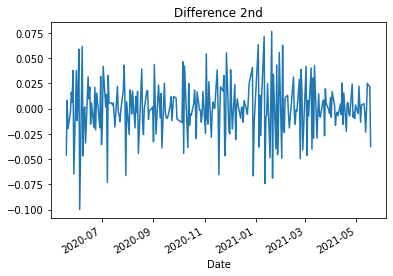

In [ ]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 561.143
Date:                Fri, 16 Dec 2022   AIC                          -1118.287
Time:                        06:45:14   BIC                          -1111.464
Sample:                             0   HQIC                         -1115.533
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0443      0.066     -0.671      0.502      -0.174       0.085
sigma2         0.0004   2.77e-05     14.095      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


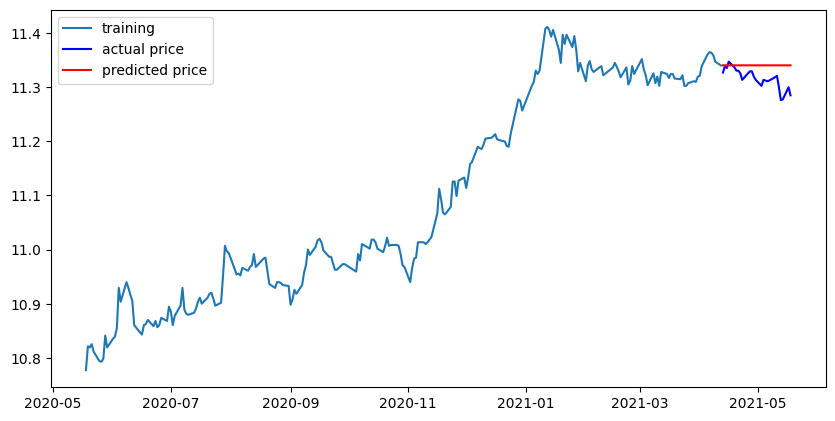

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc))
print("mse : ",mse)

mae = mean_absolute_error(np.exp(test_data),np.exp(fc))
print("mae : ",mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print("rmse : ",rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

mse :  5960523.157177396
mae :  1991.3734930935293
rmse :  2441.4182675603533
MAPE: 2.45%


# High 예측

### STEP 1 : 시계열 데이터 준비

In [ ]:
df = pd.read_csv("005930.KS.csv",index_col='Date',parse_dates=True)
ts = df['High']
ts.head()

Date
2020-05-18    49100.0
2020-05-19    50500.0
2020-05-20    50200.0
2020-05-21    50400.0
2020-05-22    49800.0
Name: High, dtype: float64

### STEP 2 : 각종 전처리 수행

In [ ]:
ts[ts.isna()]

Series([], Name: High, dtype: float64)

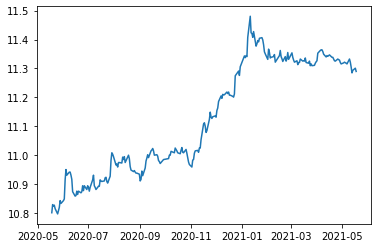

In [ ]:
ts_log = np.log(ts)
plt.plot(ts_log)

### STEP 3 : 시계열 안정성 분석

In [ ]:
def plot_rolling_statistics(timeseries,window=12): #12
  rolmean = timeseries.rolling(window=window).mean()
  rolstd = timeseries.rolling(window=window).std()

  orig = plt.plot(timeseries,color='blue',label='Original')
  mean = plt.plot(rolmean,color='red',label='mean')
  std = plt.plot(rolstd,color='black',label='std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries,autolag = 'AIC')

  print("results of dickey -fuller test : ")
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
  print(dfoutput)

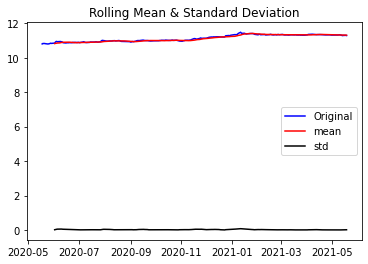

results of dickey -fuller test : 
Test Statistic                  -1.431495
p-value                          0.567087
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


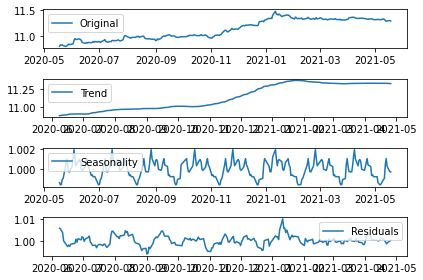

In [ ]:
plot_rolling_statistics(ts_log,window=12)

augmented_dickey_fuller_test(ts_log)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,model='multiplicative',period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()



In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

results of dickey -fuller test : 
Test Statistic                -5.997780e+00
p-value                        1.685430e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

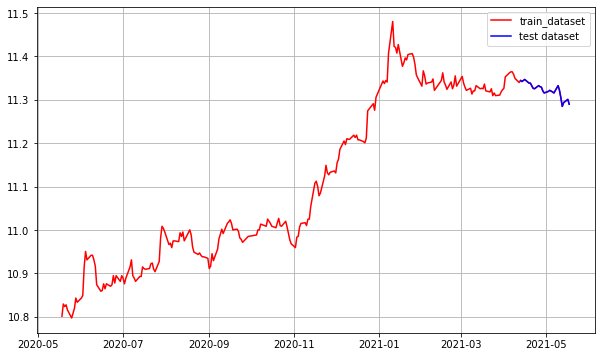

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log,c='r',label='train_dataset')
plt.plot(test_data,c='b',label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기

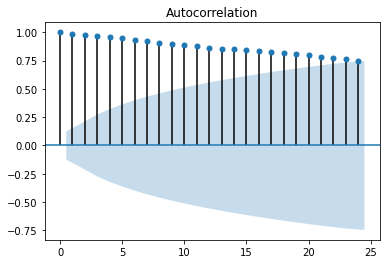

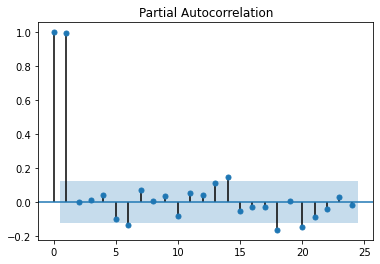

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

results of dickey -fuller test : 
Test Statistic                -1.475670e+01
p-value                        2.437648e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


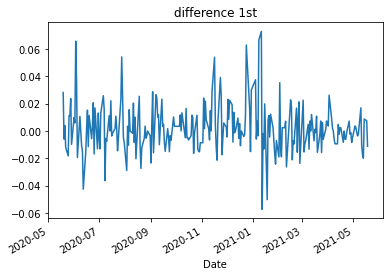

In [ ]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="difference 1st")

augmented_dickey_fuller_test(diff_1)

results of dickey -fuller test : 
Test Statistic                -7.048547e+00
p-value                        5.603906e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


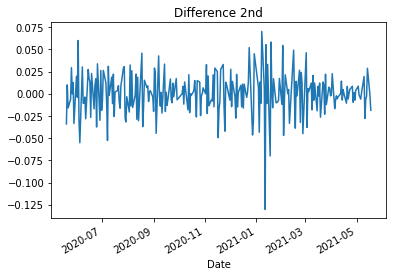

In [ ]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 578.633
Date:                Fri, 16 Dec 2022   AIC                          -1153.266
Time:                        06:46:54   BIC                          -1146.443
Sample:                             0   HQIC                         -1150.512
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0759      0.042      1.805      0.071      -0.007       0.158
sigma2         0.0003   2.11e-05     15.859      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.03   Jarque-

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


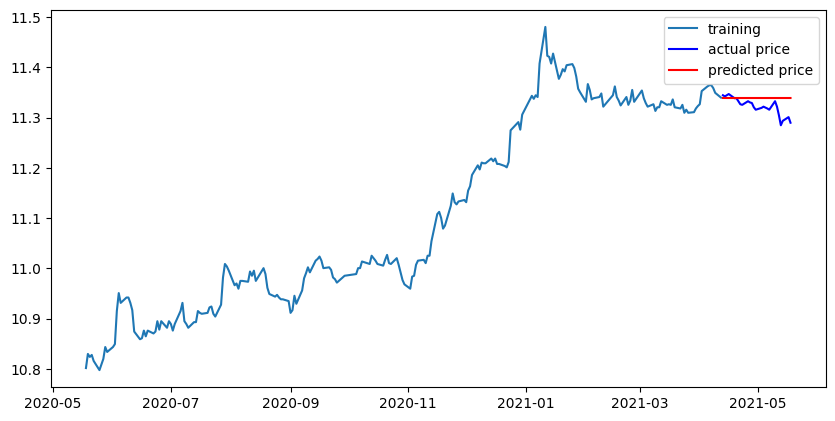

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data),np.exp(fc))
print("mse : ",mse)

mae = mean_absolute_error(np.exp(test_data),np.exp(fc))
print("mae : ",mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print("rmse : ",rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

mse :  3711373.119061836
mae :  1483.3154378395352
rmse :  1926.4924393990848
MAPE: 1.82%
